In [8]:
import tensorflow as tf
import keras
import cv2
import numpy as np 
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Add, Flatten, Dense, Dropout
from keras.models import Model
# import mnist dataset
from tensorflow.keras.datasets import mnist

from resnet import ResNet18
# load dataset
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
Y_train = Y_train.astype('float32')
Y_test = Y_test.astype('float32')


# set the colormap.
plt.rc("image",cmap="gray")

(28, 28)

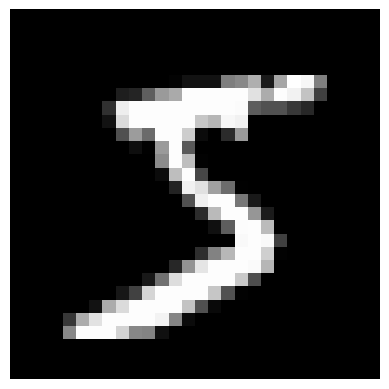

In [9]:
# example image
plt.imshow(tf.squeeze(X_train[0]))
plt.axis("off")

# get the input shape
data_input_shape = X_train[0].shape
data_input_shape

### RESNET-18

In [10]:
def residual_block(inputs, filters, strides=1):
    """
    Residual block for resnet model. It creates 2 layers of Conv2D with BatchNormalization and ReLU activation.
    Then decides whether to add a shortcut connection based on the input shape and output shape.
    """
    # layer 1. 
    # stride is variable.
    out = Conv2D(filters=filters, kernel_size=(3, 3), strides=strides, padding='same')(inputs)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    # layer 2.
    # stride is 1.
    out = Conv2D(filters=filters, kernel_size=(3, 3), strides=(1,1), padding='same')(out)
    out = BatchNormalization()(out)
    
    # decide how to shortcut
    if strides != 1 or inputs.shape[-1] != filters:
        # fix input shape to match output shape
        shortcut = Conv2D(filters=filters, kernel_size=(1, 1), strides=strides, padding='same')(inputs)
        shortcut = BatchNormalization()(shortcut)
    else:
        shortcut = out
    
    # add shortcut to main path. We didn't use concatenation because we dont want to make input bigger.
    x = Add()([out, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet18(input_shape, num_classes):
    """
    Homemade Resnet-18 model. It starts with conv and maxpooling layers. Then it has 4 layers each with 2 residual blocks. 
    Lastly, it has a flatten layer and a dense layer for classification. It is built according to "Abhishek, A. V. S.,
    Gurrala, D. V. R., & Sahoo, D. L. (2022). Resnet18 model with sequential layer for computing accuracy on image classification
    dataset. Int. J. Creat. Res. Thoughts, 10, 2320-2882." paper.
    """

    inputs = Input(shape=input_shape)
    
    # starting layers
    out = Conv2D(filters=64, kernel_size=(7, 7), strides=2, padding='same')(inputs)
    out = BatchNormalization()(out)
    out = Activation('relu')(out)
    out = MaxPooling2D(pool_size=(3, 3), strides=2, padding='same')(out)

    # residual blocks
    
    # layer 1
    out = residual_block(out, filters=64)
    out = residual_block(out, filters=64)
    
    # layer 2
    out = residual_block(out, filters=128, strides=2)
    out = residual_block(out, filters=128)
    
    # layer 3
    out = residual_block(out, filters=256, strides=2)
    out = residual_block(out, filters=256)
    
    # layer 4
    out = residual_block(out, filters=512, strides=2)
    out = residual_block(out, filters=512)
    
    # average pooling
    out = GlobalAveragePooling2D()(out)

    # classification layer
    out = Flatten()(out)
    out = Dense(units=num_classes, activation='relu')(out)
    
    model = Model(inputs=inputs, outputs=out)
    return model

# Define the input shape and number of classes
input_shape = data_input_shape
num_classes = 10


# Build the ResNet-18 model
model = build_resnet18(input_shape=(28,28,1), num_classes=10)
model.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 14, 14,    │      3,200 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 7, 7, 64)  │          0 │ activation_25[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 7, 7, 64)  │     36,928 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_26       │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 7, 7, 64)  │     36,928 │ activation_26[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_27       │ (None, 7, 7, 64)  │          0 │ add_8[0][0]       │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 7, 7, 64)  │     36,928 │ activation_27[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_28       │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 7, 7, 64)  │     36,928 │ activation_28[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 7, 7, 64)  │        256 │ conv2d_44[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_9 (Add)         │ (None, 7, 7, 64)  │          0 │ batch_normalizat… │
│                     │                   │            │ batch_normalizat

 Total params: 11,189,770 (42.69 MB)

 Trainable params: 11,180,170 (42.65 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [11]:
earlystop = keras.callbacks.EarlyStopping(
    min_delta=0.01,
    restore_best_weights=True,
    patience=20,
)



In [12]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size = 0.2,shuffle = True)
y_train_encoded = to_categorical(y_train)
y_val_encoded = to_categorical(y_val)

In [13]:
earlystop = keras.callbacks.EarlyStopping(
    min_delta=0.01,
    restore_best_weights=True,
    patience=20,
)

In [29]:
resnet_18 = ResNet18()
resnet_18(tf.zeros([1, 28,28,1]), training = True)
resnet_18.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["accuracy"])
resnet_18.summary()

Model: "res_net18_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_conv2d_180 (MyConv2D)        │ ?                      │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_72               │ ?                      │        74,368 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_73               │ ?                      │        74,368 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_74               │ ?                      │       231,296 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_75               │ ?                      │       296,192 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_76               │ ?                      │       921,344 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_77               │ ?                      │     1,182,208 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_78               │ ?                      │     3,677,696 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ residual_block_79               │ ?                      │     4,723,712 │
│ (ResidualBlock)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_11     │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ ?                      │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,189,770 (42.69 MB)

 Trainable params: 11,180,170 (42.65 MB)

 Non-trainable params: 9,600 (37.50 KB)

In [25]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_train.shape

(48000, 28, 28, 1)

In [26]:
y_train_encoded.shape

(48000, 10)

In [30]:
history = resnet_18.fit(x_train, y_train_encoded, batch_size=32,epochs=10)

Epoch 1/10
 545/1500 ━━━━━━━━━━━━━━━━━━━━ 3:18 208ms/step - accuracy: 0.8573 - loss: 0.5925

KeyboardInterrupt: 